In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import cv2
import argparse
import os
import tensorflow as tf
import keras
from imutils import paths
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#https://www.kaggle.com/prithwirajmitra/covid-face-mask-detection-dataset

masks = []
nomasks = []
data = []
labels = []

for filename in os.listdir("/content/drive/MyDrive/Colab_Notebooks/client/dataset/mask"):
  masks.append(filename)
for filename in os.listdir("/content/drive/MyDrive/Colab_Notebooks/client/dataset/no_mask"):
  nomasks.append(filename)

In [4]:
for img in masks:
  label = 'mask'
  image = load_img("/content/drive/MyDrive/Colab_Notebooks/client/dataset/mask/"+img, target_size=(224,224))
  image = img_to_array(image)
  image = preprocess_input(image)
  data.append(image)
  labels.append(label)

for img in nomasks:
  label = 'no_mask'
  image = load_img("/content/drive/MyDrive/Colab_Notebooks/client/dataset/no_mask/"+img, target_size=(224,224))
  image = img_to_array(image)
  image = preprocess_input(image)
  data.append(image)
  labels.append(label)

data = np.array(data, dtype="float32")
labels = np.array(labels)

In [5]:
labelling = LabelBinarizer()
labels = labelling.fit_transform(labels)
labels = to_categorical(labels)

In [6]:
train_generator = ImageDataGenerator(
                    rotation_range = 20,
                    zoom_range = 0.15,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.15,
                    horizontal_flip = True,
                    fill_mode="nearest"
                  )

In [7]:
(train_x,test_x,train_y,test_y) = train_test_split(data, labels, test_size = 0.20, stratify = labels, random_state = 42)

In [8]:
trainModel = MobileNetV2(input_tensor = tf.keras.layers.Input(shape = (224,224,3)),include_top = False, weights = 'imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [9]:
trainModel

In [10]:
trainModel.output         

<KerasTensor: shape=(None, 7, 7, 1280) dtype=float32 (created by layer 'out_relu')>

In [11]:
fullyConnected = trainModel.output         
fullyConnected = tf.keras.layers.AveragePooling2D(pool_size = (7,7))(fullyConnected)
fullyConnected = tf.keras.layers.Flatten()(fullyConnected)
fullyConnected = tf.keras.layers.Dense(128, activation = 'relu')(fullyConnected)
fullyConnected = tf.keras.layers.Dropout(0.5)(fullyConnected)
fullyConnected = tf.keras.layers.Dense(2, activation = 'softmax')(fullyConnected)

In [12]:
model = tf.keras.models.Model(inputs = trainModel.input, outputs = fullyConnected)

In [13]:
trainModel.layers

In [14]:
for layers in trainModel.layers:
  trainModel.trainable = False

In [20]:
print(trainModel)

In [16]:
learning_rate = 0.001
epochs = 20
batchSize = 32

opt = Adam(lr = learning_rate, decay = learning_rate/epochs)
model.compile(optimizer=opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [17]:
training = model.fit(train_generator.flow(train_x, train_y, batch_size=batchSize),
                    steps_per_epoch = len(train_x)//batchSize,
                    validation_data = (test_x,test_y),
                    validation_steps = len(test_x)//batchSize,
                    epochs = epochs,
                    verbose = 1
                    )

Epoch 1/20
25/25 [==============================] - 44s 373ms/step - loss: 0.6008 - accuracy: 0.7091 - val_loss: 0.0789 - val_accuracy: 0.9802
Epoch 2/20
25/25 [==============================] - 8s 316ms/step - loss: 0.1224 - accuracy: 0.9572 - val_loss: 0.0422 - val_accuracy: 0.9851
Epoch 3/20
25/25 [==============================] - 8s 317ms/step - loss: 0.0487 - accuracy: 0.9802 - val_loss: 0.0461 - val_accuracy: 0.9851
Epoch 4/20
25/25 [==============================] - 8s 317ms/step - loss: 0.0430 - accuracy: 0.9809 - val_loss: 0.0340 - val_accuracy: 0.9901
Epoch 5/20
25/25 [==============================] - 8s 318ms/step - loss: 0.0328 - accuracy: 0.9930 - val_loss: 0.0379 - val_accuracy: 0.9901
Epoch 6/20
25/25 [==============================] - 8s 321ms/step - loss: 0.0277 - accuracy: 0.9870 - val_loss: 0.0377 - val_accuracy: 0.9901
Epoch 7/20
25/25 [==============================] - 8s 317ms/step - loss: 0.0238 - accuracy: 0.9946 - val_loss: 0.0348 - val_accuracy: 0.9950
Epoch

In [18]:
model.save("/content/drive/MyDrive/Colab_Notebooks/client/model_trained.h5")

<function matplotlib.pyplot.show>

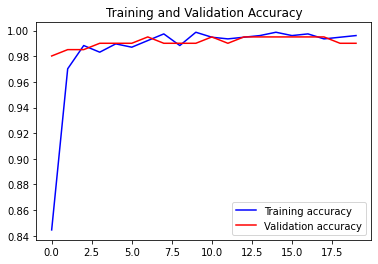

In [21]:
acc = training.history['accuracy']
val_acc = training.history['val_accuracy']
loss = training.history['loss']
val_loss = training.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show

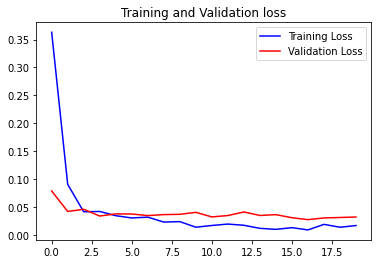

In [22]:
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()